In [1]:
import numpy as np
import tensorflow as tf
import cv2
import scipy.io
import pickle
from matplotlib import pyplot as plt

## load movie frames

In [2]:
# load input data
input_data = scipy.io.loadmat('data/2010-08-30_fish_movie_frames.mat')

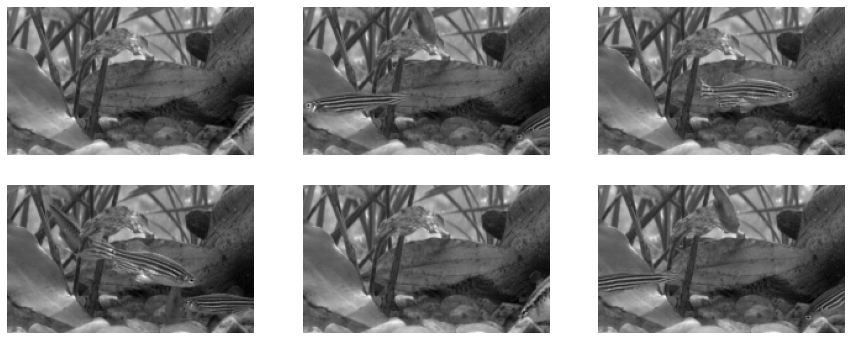

In [3]:
def show_random_frames(frames, nframes, equal = False):
    assert(len(frames) >= nframes)
    
    if equal:
        plt.figure(figsize = (12, 4*nframes//3))
    else:
        plt.figure(figsize = (15, nframes))
    
    for i in range(nframes):
        ind = np.random.randint(0,len(frames))
        plt.subplot(-(nframes//-3),3,i+1)
        plt.imshow(frames[ind], cmap='gray')
        plt.axis("off")

show_random_frames(input_data['frames'], 6)

## feature extraction using a CNN

In [4]:
def features_of_mobiltenetv2(frames):
    
    # mobilenet_v2 modle assumes image size (160, 160, 3)
    # as a result, we need to rescale images before giving them to the model.
    square_frames = np.zeros((len(frames),160,160))
    for i in range(len(frames)):
        square_frames[i] = cv2.resize(frames[i], dsize=(160,160), interpolation=cv2.INTER_CUBIC)

    # model expects pictures with 3 channels r,g,b
    # consequentlly, we need to broadcast our images into three channels
    square_frames_3ch = np.broadcast_to(square_frames.reshape(len(square_frames),160,160,1), \
                                        (len(square_frames),160,160,3)).astype(np.int32)
    
    # model expects the images in tf.tensor format; consequently, we convert type of data form np.ndarray to tf.tensor
    # moreover, model cannot process large batches; consequently we distribute the whole dataset into 10-frame batches
    input_batches = []
    num_batches_1 = len(square_frames_3ch)//10
    for i in range(num_batches_1):
        input_batches = input_batches + [tf.convert_to_tensor(square_frames_3ch[10*i:10*(i+1)])]
    input_batches = input_batches + [tf.convert_to_tensor(square_frames_3ch[10*num_batches_1:])]
    
    # the model assumes pixel values are in [-1,1] while our images have pixel values in [0,255]
    # consequently, a preprocessing layer should be added to the network to convert [0,255] interval into [-1,1]
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    
    # Create the base model from the pre-trained model MobileNet V2
    IMG_SIZE = (160,160)
    IMG_SHAPE = IMG_SIZE + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
    
    # mobilenet_v2 turns each picture batch of size (batch_sz,160,160,3) 
    # into feature batch of size (batch_sz,5,5,128)
    feature_batches = []
    for i in range(num_batches_1+1):
        feature_batches = feature_batches + [base_model(input_batches[i])]
        
    # concatenate all feature batches to form a master feature tensor
    features_tensor = feature_batches[0]
    for i in range(num_batches_1):
        features_tensor = tf.concat([features_tensor, feature_batches[i+1]], axis=0)
        
    return features_tensor

## extract features of unfiltered movie frames

In [5]:
unfiltered_features = features_of_mobiltenetv2(input_data['frames'])

## filter frames with a bilateral filter

In [6]:
# denoise all frames using the bilateral filter
bf_frames = []

for i in range(len(input_data['frames'])):
    # Apply bilateral filter with d = 15,
    # sigmaColor = sigmaSpace = 75.
    bf_frames = bf_frames + [cv2.bilateralFilter(input_data['frames'][i], 15, 20, 75)]

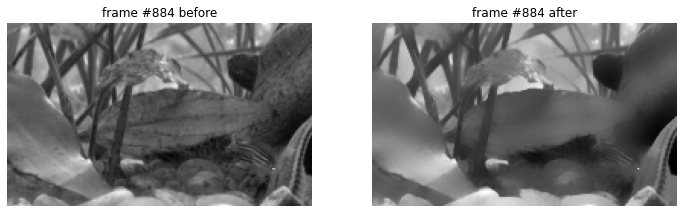

In [7]:
# show unfiltered vs. filtered frames
def show_before_after(unfiltered, filtered, nframes):
    assert(len(unfiltered)==len(filtered))
    assert(len(filtered) >= nframes)
    
    plt.figure(figsize = (12, 4*nframes))
    for i in range(nframes):
        ind = np.random.randint(0,len(filtered))
        
        plt.subplot(nframes,2,2*i+1)
        plt.imshow(unfiltered[ind], cmap='gray')
        plt.title("frame #{} before".format(ind))
        plt.axis("off")
        
        plt.subplot(nframes,2,2*i+2)
        plt.imshow(filtered[ind], cmap='gray')
        plt.title("frame #{} after".format(ind))
        plt.axis("off")
        
show_before_after(input_data['frames'], bf_frames, 1)

## extract features of filtered movie frames (bilateral filter)

In [8]:
bf_features = features_of_mobiltenetv2(bf_frames)

## compare unfiltered vs. filtered features

In [9]:
# reshape each frame's feature tensor into a column tensor

unfiltered_features = tf.reshape(unfiltered_features, [unfiltered_features.shape[0],-1])
bf_features = tf.reshape(bf_features, [bf_features.shape[0],-1])

In [10]:
# find mean absolute difference of each feature's value for unfiltered vs. filtered images
diff = tf.reduce_mean(tf.abs(unfiltered_features - bf_features), axis=0)

# sort all differences in ascending order
diff_sorted = sorted(enumerate(diff), key=lambda x: x[1].numpy())

# remove features with largest differences
kept_features = sorted([i for (i,j) in diff_sorted[0:int(len(diff_sorted)*0.5)]]) # remove 10% of largest differring features

unfiltered_features = tf.gather(unfiltered_features, indices=kept_features, axis=1)
bf_features = tf.gather(bf_features, indices=kept_features, axis=1)

# now we have a smaller feature space
print(bf_features.shape)

(1141, 16000)


In [11]:
# save the smaller feature vectors
open_file = open('data/fewer_features.pkl', 'wb')
pickle.dump(bf_features, open_file)
open_file.close()

# CODE TO OPEN THE FILE LATER:
# open_file = open('data/fewer_features.pkl', 'rb')
# loaded_list = pickle.load(open_file)
# open_file.close()

### Question: Can we remove more features? Removal of how many features is reasonable?
Probably has something to do with diff_mean and diff_mid

### To-do: Clean and readable code